In [4]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [5]:
import math

from common import *
from experiment import *
from data import DirectRawData, PlottableData

In [6]:
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False),
    TCPTreatment(cca='bbr', pep=False),
    QUICTreatment(cca='cubic'),
    QUICTreatment(cca='bbr'),
    QUICTreatment(cca='bbr1'),
]
TCP_CUBIC = TREATMENTS[0]
TCP_BBRV3 = TREATMENTS[1]
QUIC_CUBIC = TREATMENTS[2]
QUIC_BBRV3 = TREATMENTS[3]
QUIC_BBRV1 = TREATMENTS[4]

# Execute parameter space for each congestion control algorithm

In [16]:
# Plot function
def plot_3d_heatmap(data, xs, ys, zs):
    assert len(data.treatments) == 1
    treatment = data.treatments[0]
    loss  = {x: i for i, x in enumerate(xs)}
    delay = {y: j for j, y in enumerate(ys)}
    bw    = {z: k for k, z in enumerate(zs)}
    x, y, z = np.meshgrid(xs, ys, zs)

    # Flatten the grid for easier plotting
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    # Assign a heatmap value to each point
    # The goodput as a proportion of bottleneck bandwidth
    subdata = data.data[treatment]
    final_x = []
    final_y = []
    final_z = []
    final_values = []
    to_3d_index = lambda i, j, k: i*len(bw) + j*len(loss)*len(bw) + k
    for network_setting in data.exp.get_network_settings():
        network_data = subdata[network_setting.label()]
        if len(network_data) == 0:
            continue
        assert len(network_data) == 1

        # Calculate the index for the 3D point
        i = loss[network_setting.get('loss1')]
        j = delay[network_setting.get('delay1')]
        k = bw[network_setting.get('bw1')]
        index = to_3d_index(i, j, k)

        # Calculate and set the value for that point
        goodput = next(iter(network_data.values())).mean
        value = goodput / network_setting.get('bw1')
        final_x.append(float(x[index]))
        final_y.append(y[index])
        final_z.append(z[index])
        final_values.append(value)

        # Log the values at the edge of each dimension
        if i in [0, len(xs)-1] and j in [0, len(ys)-1] and k in [0, len(zs)-1]:
            print(f'({xs[i]}, {ys[j]}, {zs[k]}) -> {value:.3f}')
    
    # Plot the 3D heatmap
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with colormap
    sc = ax.scatter(final_x, final_y, final_z, c=final_values,
        cmap='viridis', s=50, alpha=0.8, vmin=0, vmax=1)

    # Add color bar for the heatmap
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Thoughput / Bandwidth')
    
    # Add axis labels
    ax.set_xlabel('Loss')
    ax.set_ylabel('Delay')
    ax.set_zlabel('Bandwidth')
    ax.set_title(treatment)
    
    # Enable rotation
    # ax.view_init(elev=20, azim=30)  # Set initial viewing angles
    # plt.ion()  # Turn on interactive mode
    plt.show()

    # Keep the plot open in interactive mode
    # input("Press Enter to exit and close the plot.")

In [17]:
def run_experiment_and_plot_3d_heatmap(treatment, loss, delay, bw, timeout=180, execute=False, num_trials=1, max_retries=10):
    data_size = lambda bw: int(10*1000000*bw/8)  # 10x the bottleneck bandwidth
    loss = list(map(str, loss))

    # Create experiment
    exp = Experiment(
        num_trials, [treatment], [], [],
        network_losses=loss,
        network_delays=delay,
        network_bws=bw,
        timeout=timeout,
        cartesian=False,
    )
    raw_data = DirectRawData(exp, execute=execute, max_retries=max_retries)

    # Plot data
    metric = 'throughput_mbps'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_3d_heatmap(plottable_data, xs=loss, ys=delay, zs=bw)

In [ ]:
run_experiment_and_plot_3d_heatmap(
    treatment=TCP_BBRV3,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100], #, 150, 200, 250]
    bw=[10, 100, 200, 300, 400, 500], #, 1000]
    execute=True,
)

run_experiment_and_plot_3d_heatmap(
    treatment=QUIC_BBRV3,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)

run_experiment_and_plot_3d_heatmap(
    treatment=QUIC_BBRV1,
    loss=[0, 0.5, 1, 2, 3, 4],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)

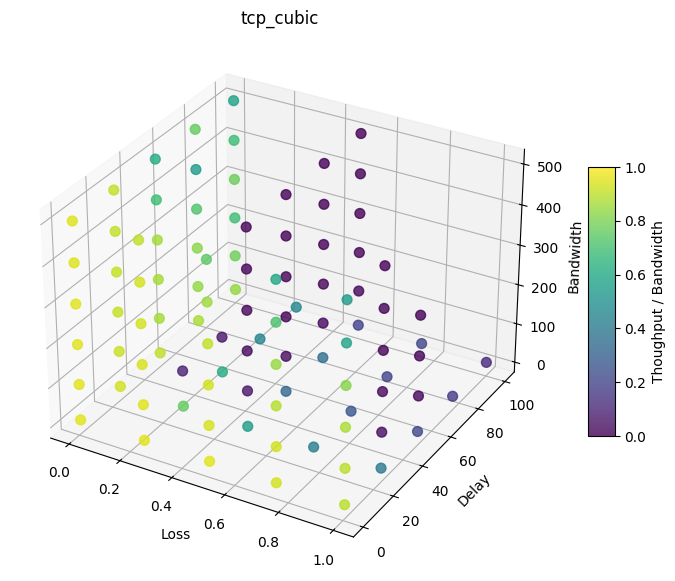

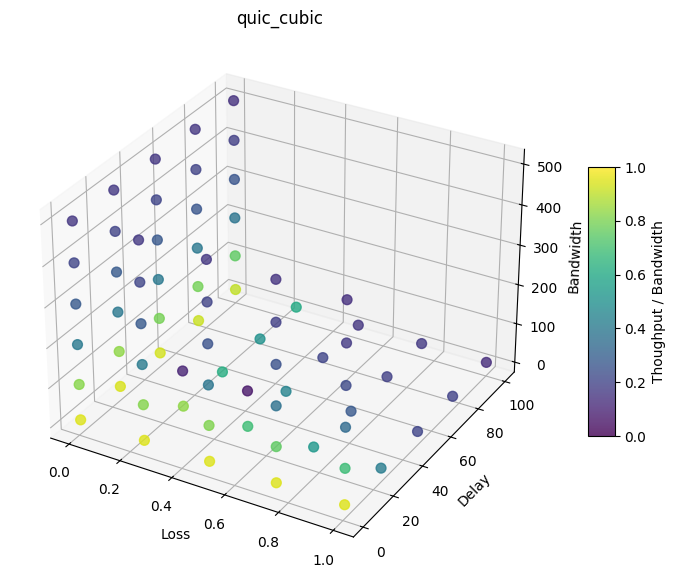

In [11]:
run_experiment_and_plot_3d_heatmap(
    treatment=TCP_CUBIC,
    loss=[0, 0.25, 0.5, 0.75, 1],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)

run_experiment_and_plot_3d_heatmap(
    treatment=QUIC_CUBIC,
    loss=[0, 0.25, 0.5, 0.75, 1],
    delay=[1, 25, 50, 75, 100],
    bw=[10, 100, 200, 300, 400, 500],
    execute=True,
)